In [21]:
'''
Demos written and developed by: Andrew E. Oriani 2020 EMAIL: oriani@uchicago.edu

'''
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

# Demonstration of pyInventor with pyEPR and Ansys HFSS modules

The following examples are given as a demonstration of automation of both 3D cavity design and HFSS simulation and analysis. To run these simulations you will need both the pyEPR module installed (these examples only work with the AndrewOriani fork of the pyEPR module) and pyInventor (https://github.com/AndrewOriani/PyInventor). After following the install instructions--and of course downloading the compatible versions of Ansys EDT and Autodesk Inventor--you will be able to run the following cells. 

## Introduction and PyInventor
The following demonstration create a single mode flute cavity (shown below) and conducts FE electromagnetic simulations using Ansys HFSS and Q3D. 


<img src="Pictures/Cavity design.png" alt="drawing" width="400">

## Eigenmode
The cells after will demonstrate setting up of the Ansys envirnoment, importing the above design into the HFSS editor and setting up a basic eigenmode simulation. Finally the eigenmode data is printed and the field participation ratios are calculated using the calculators provided. 

## Q3D 
Following eigenmode is a demonstration Q3D simulations for determining the Ec of the qubit pad geometry and the C_sigma of the qubit capacitors. This extracts the capacitance matrix from Q3D and using the C_to_Ec calculator from below to determinine Ec from C_sigma. 

## Driven Modal for Blackbox quantization
The next example is driven modal simulation to extract the admittance of the field at the qubit location. While formal blackbox quantization is not conducted in this example, the returned arrays of the imaginary component of the admittance (Im(Y11)) can be used to perform a semi-classical approximation of the cavity dispersively coupled to an anharmonic transmon qubit. To find more refer to:  https://arxiv.org/pdf/1204.0587.pdf 

## Eigenmode and pyEPR
Finally I present a modified eigenmode simulation that contains a transmon qubit. This design and layout is nearly identical to that presented in the pyEPR tutorial. This does an optimetric sweep of the linear inductance of the Josephson Junction. This is passed into the pyEPR utility to then calculate the energy participation to determine the participation of the field on the junction phase and subsequently determine the properties of the coupled qubit-cavity system.
refer to: https://arxiv.org/pdf/2010.00620.pdf and https://github.com/zlatko-minev/pyEPR

# Calculators
The first cell below are a series of calculators to analytically determine the cavity eigenmode spectrum. It determines the first n-modes of the cavity design and uses this to optimize the flute cavity dimensions to get as close as possible to the desired mode frequency. There are also functions to dtermine C_sigma of the qubit from Q3D capcitance matrices and to then determin Ec as a function of C_sigma.



In [5]:
'''
Some code for frequency estimation
'''

class unique_element:
    def __init__(self,value,occurrences):
        self.value = value
        self.occurrences = occurrences
        
def perm_unique(elements):
    eset=set(elements)
    listunique = [unique_element(i,elements.count(i)) for i in eset]
    u=len(elements)
    return perm_unique_helper(listunique,[0]*u,u-1)

def perm_unique_helper(listunique,result_list,d):
    if d < 0:
        yield tuple(result_list)
    else:
        for i in listunique:
            if i.occurrences > 0:
                result_list[d]=i.value
                i.occurrences-=1
                for g in  perm_unique_helper(listunique,result_list,d-1):
                    yield g
                i.occurrences+=1

def TE_mode_sort(mode_num=1):
    '''
    This calculates allowable nml values for the TE modes of the resonator. Uses above functions
    '''
    
    permutes=[[1,0,1],[1,0,2],[1,0,3],[1,0,4],[1,0,5],[2,0,2],[2,0,3],[2,0,4],[2,0,5],[3,0,3],[3,0,4],[3,0,5]]
    nml=[]
    for i in range(len(permutes)):
        perms=np.array(list(perm_unique(permutes[i])))
        for vals in perms:
            if vals[0]!=0 and vals[1]==0 and vals[2]!=0:
                nml.append(list(vals))
            else:
                pass
    nml=np.array(nml)
    i_sort=np.argsort(nml[:,0])
    return nml[i_sort][0:mode_num]


def freq_rect(a,b,c, modes=1, unit='metric'):
    '''
    Calculate the lowest n-mode frequencies for a rectangular cavity of a,b,c dimensions where b is the smallest dim
    '''
    if unit=='metric':
        a=a/1000.
        b=b/1000.
        c=c/1000.
    elif unit=='imperial':
        a=a*.0254
        b=b*.0254
        c=c*.0254
    else:
        raise Exception('ERROR: Unit must be metric or imperial')
    
    eps=const.epsilon_0
    mu=const.mu_0
    c_speed=const.c
    nml_array=TE_mode_sort(10)
    f=[]

    for vals in nml_array:
        n=vals[0]
        m=vals[1]
        l=vals[2]
        f.append(((c_speed)/(2*pi))*sqrt((n*pi/a)**2+(m*pi/b)**2+(l*pi/c)**2))
    f=np.array(f)
    f_sort=np.argsort(f)
    return f[f_sort][0:modes], nml_array[f_sort]

def get_c_dim(f,a,b, unit='metric'):
    '''
    Estimates the second long dimension based on a target frequency and the other two dimensions. Works only for the 
    fundamental mode
    '''
    brentq=scipy.optimize.brentq
    f_intercept=lambda c:freq_rect(a,b,c,1, unit)[0][0]-f
    c=brentq(f_intercept, min([10*a, b]), max([10*a, b]))

    return c

def round_dim(dim, frac):
    val=frac*math.ceil(dim/frac)+frac
    if (val-dim)/2<frac:
        val=val+.25
    else:
        pass
    return val

def check_path(path):
    check=glob.glob(path)
    if check==[]:
        return False
    else:
        return True

def cap_sigma(cmat, units='fF'):
    cmat=Q(cmat, units).to('F').magnitude
    return (abs(cmat[0,1])+(cmat[0,0]*cmat[1,1])/(cmat[0,0]+cmat[1,1]))

def C_to_Ec(cmat, cap_units='fF'):
    csig=cap_sigma(cmat, cap_units)
    return const.e**2/(2*(csig))/const.h

# PyInventor and cavity design:
The following shows a basic example of how to setup and compile an Inventor design using the PyInventor designs. To learn more about PyInventor and see various examples of how PyInventor can be used for cavity design please refer to: https://github.com/AndrewOriani/PyInventor and the tutorial and demo notebooks contained within.


In [6]:
"""
Single mode pan-pipe Cavity creation using inventor
"""

units='imperial'

#put in target frequency
target_freq=6.375E9 #Hz<--This is what will set the estimated cavity frequency and then try and optimize the size

#general cavity parameters
hole_spacing=.2375
hole_dia=.1875
H_stock=2.25
evan_length=.5
stock_origin=(0,0)


#calculate cavity height allowed by stock
H_cav=H_stock-2*evan_length

#calculate what you want the length of t he cavity to be for  the proper fundamental frequency
L_cav=get_c_dim(target_freq, H_cav, hole_dia, units)

#set the maximum number of holes, call them top
num_holes_top=round((L_cav-hole_dia)/hole_spacing)+1

#number of bottom holes
num_holes_bot=num_holes_top-1

#recalculate frequency now that holes are set
eff_cav_L=(num_holes_top-1)*hole_spacing+hole_dia
H_cav=get_c_dim(target_freq, eff_cav_L, hole_dia, units)

#calculate stock length for the given cavity length needed, rounds length to nearest designated fraction
L_stock=round_dim(L_cav, .25)
W_stock=round_dim(hole_dia, .125)

#start inventor and close all inventor objects
com_obj().close_all_parts()

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='Single_Mode_Pan.ipt'

#path
#path='S:\\Andrew Oriani\\CQED 3D Resonators\\Multimode Manipulate Cavity\\3D MM V3'

#for demo set the path to path='' to save in current working directory
path=''

#setup part 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

#set view as shaded with edges
part.set_visual_style(shaded=True, edges=True, hidden_edges=True)

#set starting workplane
lower_wp=part.add_workplane(plane='xy')

#attach a sketch to the workplane
sketch_1=part.new_sketch(lower_wp)

#set upper workplane
upper_wp=part.add_workplane(plane='xy', offset=H_stock)

#attach a sketch to the upper workplane
sketch_2=part.new_sketch(upper_wp)

#create stock base associated with sketch 1. The structuire object keeps track of position
stock_base=structure(part, sketch_1, start=stock_origin)

stock_base.add_line(L_stock, 180)
stock_base.add_line(W_stock, 90)
stock_base.add_line(L_stock, 0)
stock_base.add_line(W_stock, 270)

#structure identifier
base_shape=stock_base.draw_path(close_path=True)

#extrude base shape. It is important to set the object collection (obj_collection) to the specific polygon shape we created
base_extrusion=part.extrude(sketch_1, thickness=H_stock, obj_collection=base_shape, direction='positive', operation='join')

#fits whole cavity in frame
part.view.Fit()

#hole starting coordinate
hole_start=(-(L_stock-L_cav+hole_dia)/2, W_stock/2)

#structure identifier
cav_holes_top=structure(part, sketch_1, start=hole_start)
cav_holes_bot=structure(part, sketch_2, start=(hole_start[0]-hole_spacing/2, hole_start[1]))

#set total hole distance for top holes
hole_dist_top=hole_spacing*(num_holes_top-1)
hole_dist_bot=hole_spacing*(num_holes_bot-1)

#start drawing points for top holes
cav_holes_top.add_point_line(distance=hole_dist_top , direction=180, num_points=num_holes_top)   
top_holes_pos=cav_holes_top.get_pts()[0]

#create top holes by just putting in the list of positions. It will automatically make an object collection
hole_depth=H_cav+evan_length
part.new_hole(sketch=sketch_1, pos=top_holes_pos, dia=hole_dia, depth=hole_depth, direction='negative', FlatBottom=False, BottomTipAngle=None)

#start drawing holes for bottom points
cav_holes_bot.add_point_line(distance=hole_dist_bot , direction=180, num_points=num_holes_bot)   
bot_holes_pos=cav_holes_bot.get_pts()[0]

#create bottom holes
part.new_hole(sketch=sketch_2, pos=bot_holes_pos, dia=hole_dia, depth=hole_depth, direction='positive', FlatBottom=False, BottomTipAngle=None)

part.view.GoHome()

#Save document 
part.save()

#save copy as stp file for export to HFSS
path=part.save_copy_as(copy_name='single_mode_flute.stp' );

print('Estimated TE_101 mode frequency: %.3e'%target_freq)

File successfully copied as: c:\_Lib\PyInventor and pyEPR w Demos\Test Flute Cavity Notebooks\00004_single_mode_flute.stp
Estimated TE_101 mode frequency: 6.375e+09


# Eigenmode:

<img src="Pictures/Cavity Eigenmode.png" alt="drawing" width="400">

Determines first 5 eigenmode frequencies in absence of any qubit. This demonstration also calculates S_e and S_m (electric and magnetic field participation of the cavity modes) for the first (TE_101) mode.

In [12]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''

project_name='Flute_Test_EM'
design_name='Pan_pipe_Test'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\Simulation Files\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)
model.import_3D_obj(path)

#create variables for
Stock_L=EM_design.set_variable('Stock_L', '%.3fin'%(-L_stock))
Stock_W=EM_design.set_variable('Stock_W', '%.3fin'%(W_stock))
Stock_H=EM_design.set_variable('Stock_H', '%.3fin'%(H_stock))

cav_dims=[Stock_L, Stock_W, Stock_H]

box=model.draw_box_corner([0,0,0], cav_dims)
objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

bot_hole_fid=[]
for locs in bot_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    bot_hole_fid.append(fid)
    
top_hole_fid=[]
for locs in top_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    top_hole_fid.append(fid)

top_imped=model.assign_impedance(377, 0, obj_name, top_hole_fid, name='Top_Imped')
bot_imped=model.assign_impedance(377, 0, obj_name, bot_hole_fid, name='Bot_Imped')

EM_setup=EM_design.create_em_setup(name='Test_EM', 
                                   min_freq_ghz=2, 
                                   n_modes=5, 
                                   max_delta_f=0.1, 
                                   min_converged=1, 
                                   converge_on_real=True)

# time.sleep(5)

EM_setup.analyze()
solns=EM_setup.get_solutions()

# project.save()

calc=HFSS.HfssFieldsCalc(EM_setup)

calc.clear_named_expressions()

Se_calc_path=HFSS_path+"\\HFSS Calculators\\E_energy_S_to_V.clc"
Sm_calc_path=HFSS_path+"\\HFSS Calculators\\H_energy_S_to_V.clc"

Se_name=calc.load_named_expression(Se_calc_path)
Sm_name=calc.load_named_expression(Sm_calc_path)

eigen_real=solns.eigenmodes()[0]
eigen_imag=solns.eigenmodes()[1]

project.save()

print('Eigenmodes:')
print('_____________________________')
for n, (em_real, em_imag) in enumerate(zip(eigen_real, eigen_imag)):
    print('Mode #%i: %.3f+i%.3e GHz'%(n+1, em_real, em_imag))
    
print('_____________________________')

n_modes=2
Se=[]
Sm=[]
for n in range(1,n_modes+1):
    solns.set_mode(n)
    Se.append(calc.use_named_expression(Se_name).evaluate())
    Sm.append(calc.use_named_expression(Sm_name).evaluate())
    print('Se=%.3f, Sm=%.3f for mode number %i'%(Se[-1], Sm[-1], n))

INFO 03:20PM [analyze]: Analyzing setup Test_EM
Eigenmodes:
_____________________________
Mode #1: 6.187+i4.334e-10 GHz
Mode #2: 9.676+i6.688e-10 GHz
Mode #3: 9.871+i2.686e-09 GHz
Mode #4: 12.362+i3.785e-09 GHz
Mode #5: 13.624+i1.174e-05 GHz
_____________________________
Se=413.931, Sm=507.308 for mode number 1
Se=415.669, Sm=547.988 for mode number 2


# Q3D:

<img src="Pictures/Cavity Q3D.png" alt="drawing" width="400">

The below adds qubit pads (in purple) and shows how to setup a Q3D stimulation to determine the capacitance of the qubit to ground and then determined the Ec of the transmon.

In [13]:
'''
Q3D setup to determine the Ec of the qubit pads
'''

project_name='Flute_Test_Q3D'
design_name='qubit_Q3D'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\Simulation Files\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        q3d_design=project.new_q3d_design(design_name)
    else:
        q3d_design=project.get_design(design_name)
        
else:
    q3d_design=project.new_q3d_design(design_name)
        
q3d_design.make_active()
model=HFSS.HfssModeler(q3d_design)
model.import_3D_obj(path)

#create variables for the stock that we will subtract. A cool note about this: the returned
#variables (Stock_L etc) are actually turned into a special variable object that allows you to 
#do variable manipulation and automatically translate it into a string that can then be parsed
#by HFSS. Below I show some examples of this. If you return the value using the ansys module
#you will only get the string. To get the value use design.conv_variable_value and it will 
#return values in the units the document was set as in the config file. The conv_variable_value
#will only work on the Oriani revision of pyEPR/Ansys

Stock_L=q3d_design.set_variable('Stock_L', '%.3fin'%(-L_stock))
Stock_W=q3d_design.set_variable('Stock_W', '%.3fin'%(W_stock))
Stock_H=q3d_design.set_variable('Stock_H', '%.3fin'%(H_stock))

cav_dims=[Stock_L, Stock_W, Stock_H]

box=model.draw_box_corner([0,0,0], cav_dims, material='Vacuum')

objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

bot_hole_fid=[]
for locs in bot_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    bot_hole_fid.append(fid)
    
top_hole_fid=[]
for locs in top_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    top_hole_fid.append(fid)


#create some variables for the qubit hole location
Cav_W=q3d_design.create_variable('Cav_width', "%.3fin"%hole_dia)
Q_hole_len=q3d_design.create_variable('Q_hole_len', ((Stock_W-Cav_W)/2)+Cav_W/2)
Q_hole_dia=q3d_design.create_variable('Q_hole_dia', "%.3fin"%.125)

Q_hole_x=q3d_design.set_variable('Q_hole_loc_x', Stock_L/2)
Q_hole_y=q3d_design.set_variable('Q_hole_loc_y', Stock_W)
Q_hole_z=q3d_design.set_variable('Q_hole_loc_z', Stock_H/2)

Q_hole_loc=[Q_hole_x, Q_hole_y, Q_hole_z]

#create qubit hole
Q_hole=model.draw_cylinder(pos=Q_hole_loc, radius=Q_hole_dia/2, height=-Q_hole_len, axis='Y', name='Q_Hole')


#unite new feature with previous object
obj_name=model.unite([obj_name, Q_hole])

#Set chip offset into cavity
Q_chip_y_offset=q3d_design.set_variable('Q_chip_y_offset', '%.3fin'%-.05)#<---Changing this offset value will change how
                                                                         #    far inserted the chip is into the cavity     

#chip dimensions and location
Chip_W=q3d_design.set_variable('Chip_W', '%.3fmm'%2.9)
Chip_L=q3d_design.set_variable('Chip_L', '%.3fmm'%10.0)
Chip_H=q3d_design.set_variable('Chip_H','%.3fmm'%0.4)

Q_chip_x=q3d_design.set_variable('Q_chip_loc_x', Q_hole_x)
Q_chip_y=q3d_design.set_variable('Q_chip_loc_y', Stock_W/2+Chip_L/2+Q_chip_y_offset)
Q_chip_z=q3d_design.set_variable('Q_chip_loc_z', Q_hole_z)

chip_pos=[Q_chip_x, Q_chip_y, Q_chip_z]
chip_dims=[Chip_W, Chip_L, Chip_H]

#unite the chip volume with vacuum. Do not subtract or else it will set the boundaries around the chip to perf_E
chip_sub=model.draw_box_center(chip_pos, chip_dims, name='Chip_sub')
obj_name=model.unite([obj_name, chip_sub])

#create actual sapphire chip. I am using stock sapphire values but I can show how to update the material params
chip=model.draw_box_center(chip_pos, chip_dims, name='Chip', material='Sapphire')

#setup pad locations and with relation to chip
Pad_y_offset=q3d_design.set_variable('pad_y_offset', '%.3fmm'%.5)

Pad_L=q3d_design.set_variable('pad_l', '%.3fmm'%0.8)
Pad_W=q3d_design.set_variable('pad_w', '%.3fum'%350)
Pad_gap=q3d_design.set_variable('pad_gap', '%.3fum'%100)

Pad_x=q3d_design.set_variable('pad_x', Q_chip_x-Pad_W/2)
Pad_y=q3d_design.set_variable('pad_y', Q_chip_y+Pad_y_offset-Chip_L/2)
Pad_z=q3d_design.set_variable('pad_z', Q_chip_z+Chip_H/2)

#junction width
Junc_W=q3d_design.set_variable('jj_w', '%.3fum'%50)

#we'll need this for later
junc_L=q3d_design.get_variable_value(Pad_gap)

pad_loc=[Pad_x, Pad_y, Pad_z]

Pad_y_2=q3d_design.set_variable('pad_y_2', Pad_y+Pad_L+Pad_gap)
pad_loc_2=[Pad_x, Pad_y_2, Pad_z]

#create both pad. We could also duplicate along line
pad_1=model.draw_rect_corner(pos=pad_loc, x_size=Pad_W, y_size=Pad_L, name='Pad_1')
pad_2=model.draw_rect_corner(pos=pad_loc_2, x_size=Pad_W, y_size=Pad_L, name='Pad_2')

#make junction
Junc_y=q3d_design.set_variable('junc_y', Pad_y+Pad_L)
Junc_x=q3d_design.set_variable('junc_x', Pad_x+(Pad_W-Junc_W)/2)

junc_loc=[Junc_x, Junc_y, Pad_z]
jj=model.draw_rect_corner(pos=junc_loc, x_size=Junc_W, y_size=Pad_gap, name='jj')


pad_thickness=q3d_design.set_variable('pad_t', '%.4fnm'%50.0)

#setup the pads to be thin conductor and to set the signal nets for both. Setting name to None just appends the obj name with ThinCond
pad_1.make_thin_conductor(name=None, material='Copper', thickness=pad_thickness, direction='positive')
pad_2.make_thin_conductor(name=None, material='Copper', thickness=pad_thickness, direction='positive')

#now assign pads as nets
pad_1.make_net()
pad_2.make_net()


#setup q3d simulation
q3d_setup=q3d_design.create_q3d_setup(name="Ec_Test", 
                                      adaptive_freq_ghz=5.0, 
                                      min_passes=1, 
                                      max_passes=10,
                                      min_converged=1, 
                                      pct_refinement=30, 
                                      pct_error=1, 
                                      soln_order='High', 
                                      save_fields=False)

q3d_setup.analyze()

cap_matrix=q3d_setup.get_matrix_dict()['matrix']['capacitance']
cap_unit=q3d_setup.get_matrix_dict()['units']['capacitance']


project.save()

#finally I compute the Ec using the returned Q3D capacitance matrix to determine C_sigma. C_to_Ec above computes 
#the Ec in Hz

print('___________________________')
print('Estimated Ec=%.2f MHz'%(C_to_Ec(cap_matrix, cap_unit)/1E6))

INFO 03:51PM [analyze]: Analyzing setup Ec_Test
___________________________
Estimated Ec=191.74 MHz


# Driven Modal for Blackbox Quantization:

<img src="Pictures/Blackbox Quantization.png" alt="drawing" width="600">

The following modifies the above to do a driven modal simulation in order to determine the admittance of the field at the juntion. In doing so one can semi-classically approximate the participation of the juntion phase in the cavity field using the BlackBox quantization method (schematic above). To learn more about how this works refer to: https://arxiv.org/pdf/1204.0587.pdf

INFO 04:27PM [analyze]: Analyzing setup QTune_DM


(6.07410891089109, 6.10410891089109)

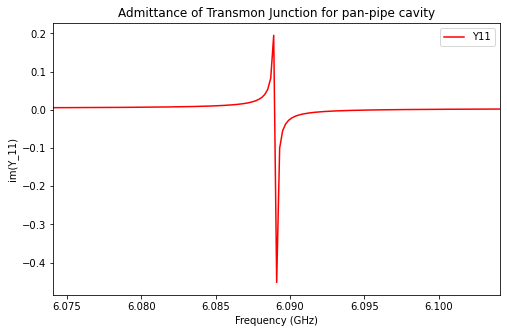

In [36]:
'''
Driven Modal setup to determine the admittance at the qubit
'''

project_name='Flute_Test_DM'
design_name='qubit_DM'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\Simulation Files\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        DM_design=project.new_dm_design(design_name)
    else:
        DM_design=project.get_design(design_name)
        
else:
    DM_design=project.new_dm_design(design_name)
        
DM_design.make_active()
model=HFSS.HfssModeler(DM_design)
model.import_3D_obj(path)

#create variables for the stock that we will subtract. A cool note about this: the returned
#variables (Stock_L etc) are actually turned into a special variable object that allows you to 
#do variable manipulation and automatically translate it into a string that can then be parsed
#by HFSS. Below I show some examples of this. If you return the value using the ansys module
#you will only get the string. To get the value use design.conv_variable_value and it will 
#return values in the units the document was set as in the config file. The conv_variable_value
#will only work on the Oriani revision of pyEPR/Ansys

Stock_L=DM_design.set_variable('Stock_L', '%.3fin'%(-L_stock))
Stock_W=DM_design.set_variable('Stock_W', '%.3fin'%(W_stock))
Stock_H=DM_design.set_variable('Stock_H', '%.3fin'%(H_stock))

cav_dims=[Stock_L, Stock_W, Stock_H]

box=model.draw_box_corner([0,0,0], cav_dims, material='Vacuum')

objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

bot_hole_fid=[]
for locs in bot_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    bot_hole_fid.append(fid)
    
top_hole_fid=[]
for locs in top_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    top_hole_fid.append(fid)


#create some variables for the qubit hole location
Cav_W=DM_design.set_variable('Cav_width', "%.3fin"%hole_dia)
Q_hole_len=DM_design.set_variable('Q_hole_len', ((Stock_W-Cav_W)/2)+Cav_W/2)
Q_hole_dia=DM_design.set_variable('Q_hole_dia', "%.3fin"%.125)

Q_hole_x=DM_design.set_variable('Q_hole_loc_x', Stock_L/2)
Q_hole_y=DM_design.set_variable('Q_hole_loc_y', Stock_W)
Q_hole_z=DM_design.set_variable('Q_hole_loc_z', Stock_H/2)

Q_hole_loc=[Q_hole_x, Q_hole_y, Q_hole_z]

#create qubit hole
Q_hole=model.draw_cylinder(pos=Q_hole_loc, radius=Q_hole_dia/2, height=-Q_hole_len, axis='Y', name='Q_Hole')


#unite new feature with previous object
obj_name=model.unite([obj_name, Q_hole])

#Set chip offset into cavity
Q_chip_y_offset=DM_design.set_variable('Q_chip_y_offset', '%.3fin'%-.05)#<---Changing this offset value will change how
                                                                         #    far inserted the chip is into the cavity     

#chip dimensions and location
Chip_W=DM_design.set_variable('Chip_W', '%.3fmm'%2.9)
Chip_L=DM_design.set_variable('Chip_L', '%.3fmm'%10.0)
Chip_H=DM_design.set_variable('Chip_H','%.3fmm'%0.4)

Q_chip_x=DM_design.set_variable('Q_chip_loc_x', Q_hole_x)
Q_chip_y=DM_design.set_variable('Q_chip_loc_y', Stock_W/2+Chip_L/2+Q_chip_y_offset)
Q_chip_z=DM_design.set_variable('Q_chip_loc_z', Q_hole_z)

chip_pos=[Q_chip_x, Q_chip_y, Q_chip_z]
chip_dims=[Chip_W, Chip_L, Chip_H]

#unite the chip volume with vacuum. Do not subtract or else it will set the boundaries around the chip to perf_E
chip_sub=model.draw_box_center(chip_pos, chip_dims, name='Chip_sub')
obj_name=model.unite([obj_name, chip_sub])

#create actual sapphire chip. I am using stock sapphire values but I can show how to update the material params
chip=model.draw_box_center(chip_pos, chip_dims, name='Chip', material='Sapphire')

#setup pad locations and with relation to chip
Pad_y_offset=DM_design.set_variable('pad_y_offset', '%.3fmm'%.5)

Pad_L=DM_design.set_variable('pad_l', '%.3fmm'%0.8)
Pad_W=DM_design.set_variable('pad_w', '%.3fum'%350)
Pad_gap=DM_design.set_variable('pad_gap', '%.3fum'%100)

Pad_x=DM_design.set_variable('pad_x', Q_chip_x-Pad_W/2)
Pad_y=DM_design.set_variable('pad_y', Q_chip_y+Pad_y_offset-Chip_L/2)
Pad_z=DM_design.set_variable('pad_z', Q_chip_z+Chip_H/2)

#junction width
Junc_W=DM_design.set_variable('jj_w', '%.3fum'%50)

#we'll need this for later
junc_L=DM_design.get_variable_value(Pad_gap)

pad_loc=[Pad_x, Pad_y, Pad_z]

Pad_y_2=DM_design.set_variable('pad_y_2', Pad_y+Pad_L+Pad_gap)
pad_loc_2=[Pad_x, Pad_y_2, Pad_z]

#create both pad. We could also duplicate along line
pad_1=model.draw_rect_corner(pos=pad_loc, x_size=Pad_W, y_size=Pad_L, name='Pad_1')
pad_2=model.draw_rect_corner(pos=pad_loc_2, x_size=Pad_W, y_size=Pad_L, name='Pad_2')

#set boundaries of pads
model.assign_perfect_E([pad_1, pad_2], name='TPads')

#make junction
Junc_y=DM_design.set_variable('junc_y', Pad_y+Pad_L)
Junc_x=DM_design.set_variable('junc_x', Pad_x+(Pad_W-Junc_W)/2)

junc_loc=[Junc_x, Junc_y, Pad_z]
jj=model.draw_rect_corner(pos=junc_loc, x_size=Junc_W, y_size=Pad_gap, name='jj')

#make the junction a port
jj.make_lumped_port(axis='Y', z0="1000ohm", name="JJ_port_1")

#add frequency sweep setup
DM_setup=DM_design.create_dm_setup(freq_ghz=1,
                                    name="QTune_DM",
                                    max_delta_s=0.1,
                                    max_passes=10,
                                    min_passes=1,
                                    min_converged=1, 
                                    pct_refinement=30,
                                    basis_order=-1
                                    )

DM_sweep=DM_setup.insert_sweep(start_ghz=5,
                                stop_ghz=7,
                                count=10000,
                                step_ghz=None,#<--If you rather use frequency step use this, otherwise use step and set to none (or vis-versa)
                                type="Fast",
                                save_fields=False)

#start analysis of the above DM setup and sweeps
DM_setup.analyze()

#return admittance array and display report
Y11_report=DM_sweep.create_report(name=DM_sweep.name, expr="im(Y(JJ_port_1,port_1))")
Y11_array=DM_sweep.get_report_arrays(expr="im(Y(JJ_port_1,JJ_port_1))")

#plot the admittance
freq=Y11_array[0]
im_Y11=Y11_array[1]

plt.figure(figsize=(8,5))
plt.plot(freq, im_Y11, '-r', label="Y11")
plt.xlabel('Frequency (GHz)')
plt.ylabel('im(Y_11)')
plt.legend()
plt.title('Admittance of Transmon Junction for pan-pipe cavity')
f0=freq[np.argmin(im_Y11)]
plt.xlim([f0-0.015, f0+0.015])


# pyEPR simulation setup:
The following is the setup and eigenmode simulation of the above example in preperation for analysis using the pyEPR toolbox. This setup is the pan-pipe equivalent of the example that is given in the pyEPR tutorial notebook. Unlike that example this one shows the full process of the setup for the pan-pipe cavity with the qubit in preperation for pyEPR analysis. For more on the physics of this refer to:  https://arxiv.org/pdf/2010.00620.pdf and https://github.com/zlatko-minev/pyEPR

In [37]:
'''
HFSS Creation for pyEPR:

In this example we take the above design and create a new simulation file that sets up the chip, adds the necessary pads
and a "junction" with a given inductance (Lj_val) and then sets up an optimetric scan. These is also other boundary 
assignments and meshing operations that allow for more accurate electric field calculations at the junction itself.

From this we will do the EPR analysis
'''


project_name='Flute_EPR_Test'
design_name='Pan_pipe_w_qubit'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\Simulation Files\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        EM_design=project.new_em_design(design_name)
    else:
        EM_design=project.get_design(design_name)
        
else:
    EM_design=project.new_em_design(design_name)
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)
model.import_3D_obj(path)

#create variables for the stock that we will subtract. A cool note about this: the returned
#variables (Stock_L etc) are actually turned into a special variable object that allows you to 
#do variable manipulation and automatically translate it into a string that can then be parsed
#by HFSS. Below I show some examples of this. If you return the value using the ansys module
#you will only get the string. To get the value use design.conv_variable_value and it will 
#return values in the units the document was set as in the config file. The conv_variable_value
#will only work on the Oriani revision of pyEPR/Ansys

Stock_L=EM_design.set_variable('Stock_L', '%.3fin'%(-L_stock))
Stock_W=EM_design.set_variable('Stock_W', '%.3fin'%(W_stock))
Stock_H=EM_design.set_variable('Stock_H', '%.3fin'%(H_stock))

cav_dims=[Stock_L, Stock_W, Stock_H]

box=model.draw_box_corner([0,0,0], cav_dims)

objs=model.get_object_names()
obj_name=model.subtract(blank_name=objs[1], tool_names=[objs[0]])

bot_hole_fid=[]
for locs in bot_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], Stock_H]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    bot_hole_fid.append(fid)
    
top_hole_fid=[]
for locs in top_holes_pos:
    loc=['%.4fin'%locs[0], '%.4fin'%locs[1], '%.4fin'%0]
    fid=model.get_face_id_by_pos(obj_name, pos=loc)
    top_hole_fid.append(fid)
    
top_imped=model.assign_impedance(377, 0, obj_name, top_hole_fid, name='Top_Imped')
bot_imped=model.assign_impedance(377, 0, obj_name, bot_hole_fid, name='Bot_Imped')


#create some variables for the qubit hole location
Cav_W=EM_design.set_variable('Cav_width', "%.3fin"%hole_dia)
Q_hole_len=EM_design.set_variable('Q_hole_len', ((Stock_W-Cav_W)/2)+Cav_W/2)
Q_hole_dia=EM_design.set_variable('Q_hole_dia', "%.3fin"%.125)

Q_hole_x=EM_design.set_variable('Q_hole_loc_x', Stock_L/2)
Q_hole_y=EM_design.set_variable('Q_hole_loc_y', Stock_W)
Q_hole_z=EM_design.set_variable('Q_hole_loc_z', Stock_H/2)

Q_hole_loc=[Q_hole_x, Q_hole_y, Q_hole_z]

#create qubit hole
Q_hole=model.draw_cylinder(pos=Q_hole_loc, radius=Q_hole_dia/2, height=-Q_hole_len, axis='Y', name='Q_Hole')


#unite new feature with previous object
obj_name=model.unite([obj_name, Q_hole])

#Set chip offset into cavity
Q_chip_y_offset=EM_design.set_variable('Q_chip_y_offset', '%.3fin'%-.05)#<---Changing this offset value will change how
                                                                         #    far inserted the chip is into the cavity     

#chip dimensions and location
Chip_W=EM_design.set_variable('Chip_W', '%.3fmm'%2.9)
Chip_L=EM_design.set_variable('Chip_L', '%.3fmm'%10.0)
Chip_H=EM_design.set_variable('Chip_H','%.3fmm'%0.4)

Q_chip_x=EM_design.set_variable('Q_chip_loc_x', Q_hole_x)
Q_chip_y=EM_design.set_variable('Q_chip_loc_y', Stock_W/2+Chip_L/2+Q_chip_y_offset)
Q_chip_z=EM_design.set_variable('Q_chip_loc_z', Q_hole_z)

chip_pos=[Q_chip_x, Q_chip_y, Q_chip_z]
chip_dims=[Chip_W, Chip_L, Chip_H]

#unite the chip volume with vacuum. Do not subtract or else it will set the boundaries around the chip to perf_E
chip_sub=model.draw_box_center(chip_pos, chip_dims, name='Chip_sub')
obj_name=model.unite([obj_name, chip_sub])

#create actual sapphire chip. I am using stock sapphire values but I can show how to update the material params
chip=model.draw_box_center(chip_pos, chip_dims, name='Chip', material='Sapphire')

#setup pad locations and with relation to chip
Pad_y_offset=EM_design.set_variable('pad_y_offset', '%.3fmm'%.5)

Pad_L=EM_design.set_variable('pad_l', '%.3fmm'%0.8)
Pad_W=EM_design.set_variable('pad_w', '%.3fum'%350)
Pad_gap=EM_design.set_variable('pad_gap', '%.3fum'%100)

Pad_x=EM_design.set_variable('pad_x', Q_chip_x-Pad_W/2)
Pad_y=EM_design.set_variable('pad_y', Q_chip_y+Pad_y_offset-Chip_L/2)
Pad_z=EM_design.set_variable('pad_z', Q_chip_z+Chip_H/2)

#junction width
Junc_W=EM_design.set_variable('jj_w', '%.3fum'%50)

#we'll need this for later
junc_L=EM_design.get_variable_value(Pad_gap)

pad_loc=[Pad_x, Pad_y, Pad_z]

Pad_y_2=EM_design.set_variable('pad_y_2', Pad_y+Pad_L+Pad_gap)
pad_loc_2=[Pad_x, Pad_y_2, Pad_z]

#create both pad. We could also duplicate along line
pad_1=model.draw_rect_corner(pos=pad_loc, x_size=Pad_W, y_size=Pad_L, name='Pad_1')
pad_2=model.draw_rect_corner(pos=pad_loc_2, x_size=Pad_W, y_size=Pad_L, name='Pad_2')

#make junction
Junc_y=EM_design.set_variable('junc_y', Pad_y+Pad_L)
Junc_x=EM_design.set_variable('junc_x', Pad_x+(Pad_W-Junc_W)/2)

junc_loc=[Junc_x, Junc_y, Pad_z]
jj=model.draw_rect_corner(pos=junc_loc, x_size=Junc_W, y_size=Pad_gap, name='jj')

#set boundaries of pads
model.assign_perfect_E([pad_1, pad_2], name='TPads')

#set jj to lumped RLC, but first create a variable for L_jj
Lj_val=11.2  #<---this sets the nominal Lj_val

L_jj=EM_design.set_variable('Lj_1', '%.3fnH'%Lj_val)
jj.make_rlc_boundary(axis='Y', r=0, l=L_jj, c=0, name='jj1_RLC')

#Need an integration line for pyEPR. Not necessary for our single qubit case but won't work without
#it for some reason. Closed needs to be false in order for itto be recognized as line object
jj_line=model.draw_polyline(jj.make_center_line(axis='Y'), closed=False, name='jj_line')

#do some meshing to better sample the E-field of the qubit and pads
model.mesh_length(name_mesh='jj', objects=[jj], max_length='%.3fum'%20)
model.mesh_length(name_mesh='pads', objects=[pad_1, pad_2], max_length='%.3fum'%100)
model.mesh_length(name_mesh='substrate', objects=[chip], max_length='%.3fmm'%1)

#setup the analysis and optimetrics
opti_setup=HFSS.Optimetrics(EM_design)

#note that the eigenmode (EM) setup has to be made first
EM_setup=EM_design.create_em_setup(name='Qubit_EM', 
                                   min_freq_ghz=4, 
                                   n_modes=2, 
                                   max_delta_f=0.5, 
                                   min_converged=1, 
                                   max_passes=20,
                                   converge_on_real=True)

#set the optimetrics step size and number of steps
step=.2
num_step=1

#create optimetrics setup
opti_setup.create_setup(variable=L_jj,
                        swp_params=('%.2fnH'%(Lj_val-num_step*step), '%.2fnH'%(Lj_val+num_step*step), '%.2fnH'%step),
                        name='Lj_Sweep',
                        solve_with_copied_mesh_only=False
                        )

#solve it
opti_setup.solve_setup('Lj_Sweep')

#save project
project.save()

#in anticipation of pyEPR we run the project info to reopen the project for EPR analysis
pinfo=pyEPR.ProjectInfo(HFSS_path,  
                         project_name,
                         design_name)


ERROR 04:31PM [mesh_length]: KEY `{key}` NOT IN ops!
ERROR 04:31PM [mesh_length]: KEY `{key}` NOT IN ops!
ERROR 04:31PM [mesh_length]: KEY `{key}` NOT IN ops!
Inserting optimetrics setup `Lj_Sweep` for simulation setup: `Qubit_EM`
INFO 05:24PM [connect]: Connecting to Ansys Desktop API...
INFO 05:24PM [load_ansys_project]: 	File path to HFSS project found.
INFO 05:24PM [load_ansys_project]: 	Opened Ansys App
INFO 05:24PM [load_ansys_project]: 	Opened Ansys Desktop v2020.1.0
INFO 05:24PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    c:/_Lib/PyInventor and pyEPR w Demos/Test Flute Cavity Notebooks/
	Project:   Flute_EPR_Test_2
INFO 05:24PM [connect]: 	Opened active design
	Design:    Pan_pipe_w_qubit [Solution type: Eigenmode]
INFO 05:24PM [get_setup]: 	Opened setup `Qubit_EM`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:24PM [connect]: 	Connection to Ansys established successfully. 😀 



# pyEPR Analysis

The following takes the above and conducts the rest of the EPR analysis and returns the the energy participation ratios as well as the anharmonicities, coupling strengths and cross-kerrs for each variation of the qubit inductance with each mode (as determined in the above eigenmode simulation)

In [38]:
'''
pyEPR analysis. 

Once the variations have been calculated we can proceed to do the EPR analysis. The following loads the above into the
pinfo object used by pyEPR for 

'''

#make sure you use the correct variable names otherwise this will not work correctly
pinfo.junctions['j1'] = {'Lj_variable' : str(L_jj), 
                         'rect'        : str(jj),  
                         'line'        : str(jj_line),
                         'length'      : pyEPR.parse_units(junc_L)}

project=pinfo.project

#this just makes sure everything is kosher (copacetic if you are Vatsan)
pinfo.validate_junction_info()

#setup for EPR anaylsis
eprh = pyEPR.DistributedAnalysis(pinfo)

Design "Pan_pipe_w_qubit" info:
	# eigenmodes    2
	# variations    3


In [39]:
'''
Taken from the pyEPR tutorial, just checks the analysis folders for the various variations
'''

for variation in eprh.variations[:2]: # just for the first 2
    Fs, Qs = eprh.get_freqs_bare_pd(variation=variation, frame=False)
    display(pd.DataFrame({'Freq. (GHz)':Fs, 'Quality Factor':Qs}))

,Freq. (GHz),Quality Factor
0,5.298758,7.318659e+11
1,6.118611,1.674189e+09


,Freq. (GHz),Quality Factor
0,5.255700,9.604096e+11
1,6.117746,1.404532e+09


In [40]:
# Do EPR analysis for all modes and all variations 
# If you want to only analze a certain variation, you can change the 
# default keyword argeumetns variations=None, modes=None
eprh.do_EPR_analysis(variations=None, modes=None);


Variation 0  [1/3]

  Mode 0 at 5.30 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               95.5%   1.17e-23 5.267e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.62%
	j1              0.953868  (+)        0.0232605
		(U_tot_cap-U_tot_ind)/mean=1.21%

  Mode 1 at 6.12 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                2.6%  3.502e-22 3.411e-22

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.85%
	j1              0.0245394  (+)        0.000797905
		(U_tot_cap-U_tot_ind)/mean=0.11%

Variation 1  [2/3]

  Mode 0 at 5.26 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E   

	 Differences in variations:


variation,0,1,2
_Lj_1,11nH,11.199999999999999nH,11.4nH





 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.024987
1    1.046917
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    11nH
Name: 0, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.932185
1  0.024520

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.96
     0.025

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       216     12.8
      12.8    0.189

*** Chi matrix ND (MHz) 
       249     7.04
      7.04   0.0682

*** Frequencies O1 PT (MHz)
0    5076.754853
1    6112.032447
dtype: float64

*** Frequencies ND (MHz)
0    5064.652705
1    6113.251896
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 1

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.024885
1    1.043909
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    11.199999999999999nH
Name: 1, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.935104
1  0.021940

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.96
     0.022

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       217     11.6
      11.6    0.154

*** Chi matrix ND (MHz) 
       250     6.56
      6.56   0.0582

*** Frequencies O1 PT (MHz)
0    5032.617263
1    6111.801731
dtype: float64

*** Frequencies ND (MHz)
0    5020.529527
1    6112.852486
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 2

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.024918
1    1.047108
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Lj_1    11.4nH
Name: 2, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.937623
1  0.019666

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.96
      0.02

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       219     10.5
      10.5    0.126

*** Chi matrix ND (MHz) 
       251      6.1
       6.1   0.0497

*** Frequencies O1 PT (MHz)
0    4987.350362
1    6111.250331
dtype: float64

*** Frequencies ND (MHz)
0    4975.268956
1    6112.155716
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


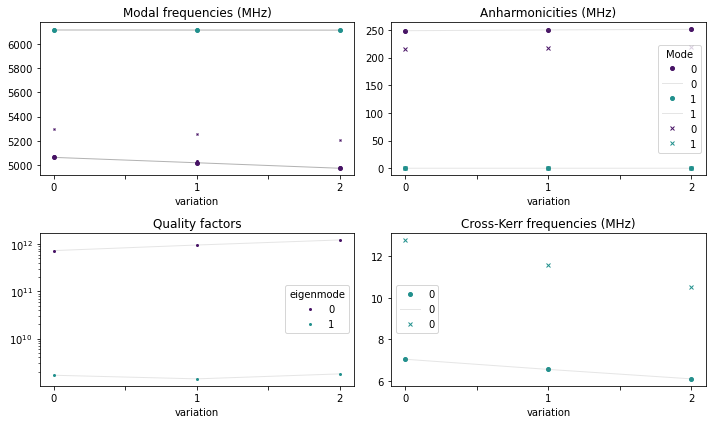

In [41]:
# This is the core object for working with post processing data from HFSS
# This iwll load the saved solutions from above
epra = pyEPR.QuantumAnalysis(eprh.data_filename)

# Analyze 
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15)
epra.plot_hamiltonian_results()

In [42]:
#Custom sort of columns
def do_sort_index(df:pd.DataFrame):
    if isinstance(df, pd.DataFrame):
        df.columns = df.columns.astype(float)
        return df.sort_index(axis=1)
    else:
        return df

epra.results.do_sort_index = do_sort_index
df = epra.results.get_frequencies_HFSS(vs='Lj_1')
df

Lj_1,11.0,11.2,11.4
eigenmode,,,
0,5298.757810,5255.699589,5211.234533
1,6118.611052,6117.746360,6116.628028
